In [1]:
# base
import pandas as pd 
import geopandas as gpd
import numpy as np
import zipfile
import os
import datetime
import random

# graph
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns

# ML
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler, RobustScaler
import pmdarima
import numba
from statsmodels.tsa.api import SARIMAX
from sktime.datatypes import check_raise, convert_to
from sklearn.linear_model import LinearRegression
from sktime.transformations.series.dummies import SeasonalDummiesOneHot

# function
import famDataset
# force reload to not restart jupyter each time
from importlib import reload
reload(famDataset)

<module 'famDataset' from '/home/tibo/Documents/Github/projet-fil-rouge-TiboGar-1/data/famDataset.py'>

In [2]:
# ----------------------------- #
# User input
# ----------------------------- #

# Interest species
especeVec = ['Avoine', 'Blé dur', 'Blé tendre', 'Colza', 'Céréales autres',
            'Féverole', 'Lin', 'Légumineuses autres', 'Maïs', 'Orge', 'Pois',
            'Seigle', 'Soja', 'Sorgho', 'Tournesol', 'Triticale']
espece= especeVec[2]

# Endogeneous variable 
variableVec = ['TOTAL_COLLECTE', 'STOCKS', 'STOCKS_DEPOTS', 'ENTREE_DEPOT',
                'SORTIE_DEPOT', 'REPRISE_DEPOT', 'CORRECT_COLLECTE', 'ENTREE',
                'LAG_DIFF', 'SORTIE']
variable= 'SORTIE'

# SARIMAX parameters
# The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters.
# The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters.
# trend parameter controlling the deterministic trend polynomial: [*0*,1,0,1]
# it can be extended, but the constant is determined by the serie mean thus fixed to 0, for robustness.

# exog boolean for using monthly dummies

args_sarimax = {'p':1,'d':0,'q':0,'P':1,'D':0,'Q':0,'trend':[0,1,1,0],'exog': True}

# Multithreading for sarima inference - double edge sword:
# - on my core i3 with 2 physical core its pointless, CPU are already maxed with apply. 
# - on better CPU its maybe worthwile

multithreading = False

Grid allowing to test:

- the species
- the interest variable (default: SORTIES)
- SARIMA parameters
- Clustering parameters

It must ouput:
- SARIMA average performance: AIC or BIC for each series
- Clustering performance: DWT

In [3]:
# ----------------------------- #
# Load dataset
# ----------------------------- #
fam = famDataset.famDataset(root_dir=os.getcwd())
fam.load_transformed_data(convert_attributes = True, drop_attributes = False, pivot_to_long = False)
fam.load_geometry_data()

fam_data = fam.transformed_data.copy()

# load dataset
df = famDataset.make_sktime_multiindex(fam_data, especes = espece, variable= variable)
#fam_data.head()

Raw data loading complete
Raw data processed in transformed_data
Geom data loading complete


In [4]:
# ----------------------------- #
# temporal model function
# ----------------------------- #

def fun_ts(y, args_sarimax):
    # fix the period warning
    y.index.freq = 'MS'
    mu_y = np.mean(y) 
    demean_y = (y - mu_y)

    # create seasonal dummies, excluding first month
    if(args_sarimax['exog']):
        transformer = SeasonalDummiesOneHot(freq='M', drop= True)
        X_seas = transformer.fit_transform(y=y, X=None)
    else:
        X_seas = None

    # set it up according to user input
    arima_coef = [args_sarimax['p'],args_sarimax['d'],args_sarimax['q']]

    seas_coef = [args_sarimax['P'],args_sarimax['D'],args_sarimax['Q'],12]

    # sarima model
    model = SARIMAX(endog = demean_y, 
                    exog = X_seas,
                    trend = args_sarimax['trend'],
                    order= arima_coef,
                    seasonal_order= seas_coef)

    # fitting model
    result = model.fit(disp=True, maxiter = 1000)
    print(result.mle_retvals['fopt'])

    # if function doesn't converge, use non-gradient method powell
    if(not result.mle_retvals['converged']):
        result = model.fit(disp=True, maxiter = 1000, method = 'powell', start_params = result.mle_retvals['gopt'])
        print(result.mle_retvals['fopt'])
        
    # building the result dataframe
    params = result.params

    params['intercept'] = mu_y
    params['aic'] = result.info_criteria('aic')
    params['bic'] = result.info_criteria('bic')
    params['llk'] = result.llf

    r_squared = 1 - (np.sum(result.resid**2, axis = 0) / np.sum((y.values - np.mean(y))**2, axis = 0))
    params['r_squared'] = r_squared

    return(params)


In [5]:
# ----------------------------- #
# Batch launch
# ----------------------------- #

if(multithreading):
    from multiprocessing import Pool, cpu_count

    def worker(args):
        dep, series = args
        series_by_date = series.droplevel('DEP')           # index = DATE
        out = fun_ts(series_by_date)                       # returns Series indexed by DATE
        out.name = dep
        return out

    # prepare inputs: list of (dep, group_series)
    groups = list(df['SORTIE'].groupby(level='DEP'))

    # choose number of processes (avoid using all cores if you need responsiveness)
    nprocs = max(1, cpu_count() - 1)

    with Pool(nprocs) as pool:
        results = pool.map(worker, groups)

    inf_res = pd.concat(results, axis=1)   # index = DATE, columns = DEP

else:
    inf_res = df['SORTIE'].groupby(level='DEP').apply(lambda g: fun_ts(g.droplevel('DEP'),args_sarimax))

10.946844567525169
11.530131427514263
10.280923764837453
7.245992456199211
8.357756140080564


/home/tibo/Documents/Github/projet-fil-rouge-TiboGar-1/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4.950859082758429
Optimization terminated successfully.
         Current function value: 5.694552
         Iterations: 23
         Function evaluations: 3895
5.694552025955964
8.967183503191237
10.634684165682561
9.681197825548496
11.74475184614448
9.265996082832144
9.029134181414673
10.391892835752662
11.530003149449
6.875735068001284
11.325339071745697
12.113735049055649
11.426225369889247
8.228383609228755
11.366902025952854
11.853840923025581
8.633983017934403
10.097366757888079
9.276602427699105
10.409381776849497
11.652133721273003
11.592546383632401
11.66458978944765
3.8919805046766176
6.003329227304145
7.6729194923321815
10.981139048255743
11.189924186538185
10.287978291756001
8.129920622899935
11.488396928057439
10.953957074068782
11.408785329884575
10.41952486731719
9.947917812009823
8.77815326836821
11.230361395637864
9.802130436588483
9.598437246346254
11.390745965146502
11.130270340966334
8.731518718096268
10.846135353173539
9.52983930236241
11.291526969352613
11.538227915

In [6]:
# ----------------------------- #
# Convert results to a dataframe
# ----------------------------- #
arr = inf_res.values.reshape(-1, len(inf_res.loc['01']))  
DEPVec = fam_data['DEP'].unique()

df_inf_res = pd.DataFrame(arr, index=pd.Index(DEPVec, name='DEP'), columns= inf_res.loc['01'].index)

df_inf_res

# test:
# all columns are float, except DEP
# r_squared are between 0 and 1


# save
df_inf_res.to_csv(espece.replace(" ", "") + '-inference.csv')



In [7]:
df_inf_res.values
#pd.to_numeric(df_inf_res.iloc[:,1])

#df_inf_res.apply(pd.to_numeric)

array([[ 1.70931347e+01, -7.67089533e-02,  6.55477468e+03, ...,
         6.74715394e+03, -3.32784075e+03,  2.92730206e-01],
       [-3.63605584e+01,  1.67893848e-01, -2.67234418e+03, ...,
         7.10179235e+03, -3.50515995e+03,  2.80322274e-01],
       [ 2.07715818e+00, -7.94908217e-03,  1.34374339e+03, ...,
         6.34227409e+03, -3.12540082e+03,  1.06336913e-01],
       ...,
       [ 2.95629120e-01, -1.82300282e-03,  7.49782397e+01, ...,
         4.34521890e+03, -2.12687323e+03,  4.96255303e-01],
       [ 1.87398171e-01, -1.57098305e-03,  4.68032428e+01, ...,
         4.52728394e+03, -2.21790575e+03,  4.40369685e-01],
       [ 4.62549238e+00, -1.58217621e-02, -2.99559317e+03, ...,
         6.40397969e+03, -3.15625362e+03,  1.57420369e-01]],
      shape=(96, 21))

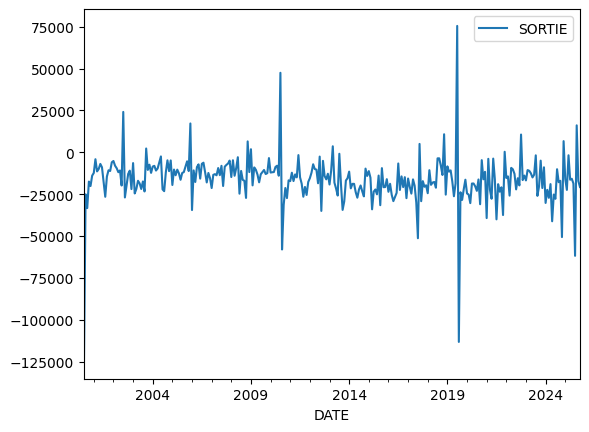

10.981139048255743


drift                    30.963649
trend.2                  -0.163344
Feb                    2208.171829
Mar                      -80.68817
Apr                     1026.32383
May                      779.79183
Jun                   -2032.600168
Jul                    1546.591676
Aug                   -6135.677555
Sep                   -1918.877555
Oct                     835.618599
Nov                      49.499829
Dec                    4676.707829
ar.L1                    -0.220803
ar.S.L12                  0.032184
sigma2            159091661.797847
intercept            -16137.287829
aic                    6708.532541
bic                    6768.004985
llk                   -3338.266271
r_squared    [0.07184896677763497]
dtype: object

In [8]:
y = df.loc['31']

y.plot()
plt.show()

fun_ts(y, args_sarimax)


In [9]:
# fix the period warning
y.index.freq = 'MS'

# create seasonal dummies, excluding first month
if(args_sarimax['exog']):
    transformer = SeasonalDummiesOneHot(freq='M', drop= True)
    X_seas = transformer.fit_transform(y=y, X=None)
else:
    X_seas = None

# set it up according to user input
arima_coef = [args_sarimax['p'],args_sarimax['d'],args_sarimax['q']]

seas_coef = [args_sarimax['P'],args_sarimax['D'],args_sarimax['Q'],12]

# sarima model
model = SARIMAX(endog = y, 
                exog = X_seas,
                trend = args_sarimax['trend'],
                order= arima_coef,
                seasonal_order= seas_coef)

# fitting model
result = model.fit(disp=True, maxiter = 1000)
print(result.mle_retvals['fopt'])

# if function doesn't converge, use non-gradient method powell
if(not result.mle_retvals['converged']):
    result = model.fit(disp=True, maxiter = 1000, method = 'powell', start_params = result.mle_retvals['gopt'])
    print(result.mle_retvals['fopt'])
    
# building the result dataframe
params = result.params

params['aic'] = result.info_criteria('aic')
params['bic'] = result.info_criteria('bic')
params['llk'] = result.llf

r_squared = 1 - (np.sum(result.resid**2, axis = 0) / np.sum((y.values - np.mean(y))**2, axis = 0))
params['r_squared'] = r_squared

params

11.019147466086


drift                      9.353955
trend.2                   -0.094386
Feb                   -13929.116002
Mar                   -16217.975997
Apr                   -15110.963997
May                   -15357.495997
Jun                   -18169.887996
Jul                   -14590.696152
Aug                   -22272.965382
Sep                   -18056.165382
Oct                   -15301.669228
Nov                   -16087.787998
Dec                   -11460.580002
ar.L1                     -0.219633
ar.S.L12                   0.154818
sigma2             180255531.641689
aic                     6731.641659
bic                     6791.114103
llk                     -3349.82083
r_squared    [-0.01308144611127049]
dtype: object

In [10]:
# ----------------------------- #
# clustering
# ----------------------------- #